In [1]:
# Edited by: Kok Teng Ng (1936360), Minjeong Lee (1978925)
# IE 678 Deep Learning, University of Mannheim
# Author: Rainer Gemulla

# Deep Learning: Assignment 2

In [2]:
%matplotlib ipympl

# Define imports & defaults
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# import helper functions
import os
import sys

sys.path.append(os.getcwd())
from a02helper import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)  # ensure reproducibility
np.random.seed(0)

MAX_SEQ_LEN = 200
BATCH_SIZE = 32

## Task 1: Datasets

In [3]:
import string
from torchtext.vocab import vocab
from torchtext.data import get_tokenizer

class ReviewsDataset(Dataset):
    def __init__(
        self,
        reviews_file="data/reviews_small.txt",
        labels_file="data/labels_small.txt",
        use_vocab=False,
    ):
        """
        A dataset of movie reviews and their labels.

        Args:
            reviews_file: the reviews file
            labels_file:  the labels file
            use_vocab: if True, yield reviews in a numerical representation
        """
        # Load data from filesystem
        with open(reviews_file) as f:
            raw_reviews = f.readlines()

        with open(labels_file) as f:
            raw_labels = f.readlines()

        # Preprocessing and store (in memory)
        self._reviews = self._preprocess_reviews(raw_reviews)
        self._labels = self._preprocess_labels(raw_labels)

        # Build vocabulary
        self.vocab = None
        if use_vocab:
            from torchtext.vocab import build_vocab_from_iterator
            self.vocab = build_vocab_from_iterator(
                self._reviews, specials=["<pad>"]  # will get token id 0
            )

    def __len__(self):
        """Returns the length of the dataset."""
        return len(self._reviews)

    def __getitem__(self, idx):
        """
        Returns a tuple of a preprocessed review and the corresponding label. If the
        vocabulary is enabled, returns a numerical representation of the review.

        Args:
            idx: a single index
        Returns: a (review, label) tuple
        """
        review = self._reviews[idx]
        label = self._labels[idx]        
        if self.vocab is not None:
            #review_ids = self.vocab([token for token in review])
            review_ids = [self.vocab[token] for token in review if token in self.vocab]
            return review_ids, label
        else:
            return review, label

    def _preprocess_reviews(self, raw_reviews):
        """
        Applies two kinds of preprocessing:

        (i) Apply the "basic_english" tokenizer from the torchtext library to
        transform every review into a list of normalized tokens (cf.
        https://pytorch.org/text/stable/data_utils.html#get-tokenizer).

        (ii) Remove punctuation (cf.
        https://docs.python.org/3/library/string.html#string.punctuation).

        Returns: list of tokenized reviews
        """
        tokenizer = get_tokenizer("basic_english")
        punctuation = set(string.punctuation)

        processed_reviews = []
        for review in raw_reviews:
            processed_review = tokenizer(review.strip().lower())
            processed_review = [tok for tok in processed_review if tok not in punctuation]
            processed_reviews.append(processed_review)
        return processed_reviews

    def _preprocess_labels(self, raw_labels):
        """
        Transform raw labels into integers, where 1="positive" and 0 otherwise.

        Returns: list of labels
        """
        # Hint: You can remove leading and trailing whitespace from the raw labels using
        # the strip() method.
        preprocessed_labels_list = []
        for label in raw_labels:
            label = label.strip()
            if label == "positive":
                preprocessed_labels_list.append(1)
            else:
                preprocessed_labels_list.append(0)
        return preprocessed_labels_list

In [4]:
# Test your code (without vocabulary).
dataset = ReviewsDataset()
print(dataset[0])

# Should yield:
# (['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', ... ], 1)

(['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', 'it', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life', 'such', 'as', 'teachers', 'my', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'bromwell', 'high', 's', 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', 'teachers', 'the', 'scramble', 'to', 'survive', 'financially', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', 'teachers', 'pomp', 'the', 'pettiness', 'of', 'the', 'whole', 'situation', 'all', 'remind', 'me', 'of', 'the', 'schools', 'i', 'knew', 'and', 'their', 'students', 'when', 'i', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school', 'i', 'immediately', 'recalled', 'at', 'high', 'a', 'classic', 'line', 'inspector', 'i', 'm', 'here', 'to', 'sack', 'one', 'of', 'your', 'teachers', 'student', 'welcome', 'to', 'brom

In [5]:
# Test your code (with vocabulary).
dataset = ReviewsDataset(use_vocab=True)
print(dataset[0])

# Should yield:
# ([10661, 307, 6, 3, 1177, 202, 8,  ... ], 1)

([10661, 307, 6, 3, 1177, 202, 8, 2248, 33, 1, 168, 56, 15, 49, 85, 8902, 43, 422, 122, 140, 15, 3234, 59, 144, 9, 1, 5504, 6267, 454, 72, 5, 260, 12, 10661, 307, 13, 2060, 6, 73, 2780, 5, 692, 76, 6, 3234, 1, 29527, 5, 1730, 7117, 1, 6161, 1726, 36, 52, 68, 212, 143, 63, 1409, 3234, 17974, 1, 28056, 4, 1, 221, 758, 31, 2748, 72, 4, 1, 6311, 10, 731, 2, 63, 1726, 54, 10, 208, 1, 321, 9, 64, 3, 1601, 4042, 743, 5, 2853, 187, 1, 422, 10, 1254, 10116, 33, 307, 3, 380, 322, 6162, 10, 135, 136, 5, 10172, 30, 4, 134, 3234, 1601, 2545, 5, 10661, 307, 10, 529, 12, 113, 1841, 4, 59, 676, 103, 12, 10661, 307, 6, 227, 4163, 48, 3, 2201, 12, 8, 231, 21], 1)


## Task 2: Data Loaders

In [6]:
# Split dataset into training, validation, and test subsets
dataset = ReviewsDataset(use_vocab=True)
train_set, val_set, test_set = torch.utils.data.random_split(
    dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(123)
)

### Task 2a

In [7]:
# Example usage of a data loader
dataloader = DataLoader(
    val_set,  # a dataset
    1,  # desired batch size
    False,  # whether to randomly shuffle the dataset
    num_workers = 0,  # number of workers that construct batches in parallel
)

In [8]:
# Let's print the first batch
batch = next(iter(dataloader))
print(batch)
# [[tensor([11]), tensor([6]), tensor([1]), ...], tensor([0])]

[[tensor([11]), tensor([6]), tensor([1]), tensor([1037]), tensor([6578]), tensor([4]), tensor([10]), tensor([89]), tensor([120]), tensor([48]), tensor([163]), tensor([47]), tensor([6]), tensor([27]), tensor([342]), tensor([4]), tensor([2228]), tensor([140]), tensor([3]), tensor([186]), tensor([1466]), tensor([1]), tensor([771]), tensor([26]), tensor([78]), tensor([1459]), tensor([200]), tensor([1101]), tensor([1]), tensor([66]), tensor([26]), tensor([78]), tensor([5199]), tensor([5]), tensor([2288]), tensor([1]), tensor([7861]), tensor([6591]), tensor([2]), tensor([83]), tensor([2446]), tensor([25]), tensor([1]), tensor([182]), tensor([2756]), tensor([2520]), tensor([34]), tensor([1]), tensor([145]), tensor([8]), tensor([13]), tensor([39]), tensor([290]), tensor([25]), tensor([252]), tensor([14480]), tensor([32]), tensor([52]), tensor([497]), tensor([9]), tensor([223]), tensor([1]), tensor([3254]), tensor([25]), tensor([937]), tensor([2]), tensor([153]), tensor([568]), tensor([5]), ten

In [9]:
print(len(val_set[0][0]))
print(len(val_set[1][0]))
print(len(val_set[2][0]))

116
158
131


The current code in cell [7] treats each review (a row of input sequence data) as an individual batch. This becomes problematic because reviews can have different lengths. By default, PyTorch’s DataLoader expects all elements in a batch to be the same size. When the batch size increases, mixing reviews of varying lengths leads to error in DataLoader( ).

To overcome this challenge, we can define a maximum sequence length for the input data. This essentially sets a cap on the length of each review. If a review exceeds the limit, we can truncate it by keeping only the first words up to the maximum length. Conversely, shorter reviews can be padded with a special token (like PAD, in our case we are using 0 instead of PAD) to ensure all reviews within a batch have the same length without causing error from DataLoader( ). This padding technique effectively increase the length of shorter reviews to match the maximum.



### Task 2b

In [10]:
def review_collate_fn(raw_batch):
    """Prepare batches of reviews from a review dataset.

    Args:
        raw_batch: collection of (review, label)-tuples from a ReviewDataset

    Returns: a tuple (review x token id tensor, label tensor) of sizes
    batch_size*MAX_SEQ_LEN and batch_size, respectively.

    """
    reviews, labels = zip(*raw_batch)
    padded_reviews = torch.zeros(len(reviews), MAX_SEQ_LEN, dtype=torch.long)
    
    for i, review in enumerate (reviews):
        if len(review) <= MAX_SEQ_LEN:
            padded_reviews[i, :len(review)] = torch.tensor(review)
        else:
            padded_reviews[i, :] = torch.tensor(review[:MAX_SEQ_LEN])
    label_tensor = torch.tensor(labels, dtype=torch.long)
    return padded_reviews, label_tensor

In [11]:
# Test your function
review_collate_fn([([1, 2, 3], 1), (torch.arange(MAX_SEQ_LEN * 2) + 1, 0)])

# Should yield:
# (tensor([[  1,   2,   3,   0,   0,  ..., 0 ],
#          [  1,   2,   3,   4,   5, ..., 200 ]]),
#  tensor([1, 0]))

/var/folders/2h/v65x911156j8d_r4wnykkqrw0000gn/T/ipykernel_69126/4265134515.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_reviews[i, :] = torch.tensor(review[:MAX_SEQ_LEN])


(tensor([[  1,   2,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0, 

In [12]:
# Create the data loaders (with shuffling for training data -> randomization)
train_loader = DataLoader(train_set, BATCH_SIZE, True, collate_fn=review_collate_fn)
val_loader = DataLoader(val_set, BATCH_SIZE, False, collate_fn=review_collate_fn)
test_loader = DataLoader(test_set, BATCH_SIZE, False, collate_fn=review_collate_fn)

In [13]:
# Let's print the first batch
batch = next(iter(val_loader))
print(batch)


# (tensor([[   11,     6,     1,  ...,     0,     0,     0],
#         [   11,   170,  2220,  ...,     0,     0,     0],
#         [   48,     3, 30376,  ...,     0,     0,     0],
#         ...,
#         [  176,    56,    10,  ...,     0,     0,     0],
#         [  239,   534,  1404,  ...,    44,   120,     1],
#         [ 2954, 15576,     6,  ...,  2678,    65,     1]]),
#  tensor([0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
#         0, 0, 0, 1, 1, 1, 0, 0]))

(tensor([[   11,     6,     1,  ...,     0,     0,     0],
        [   11,   170,  2220,  ...,     0,     0,     0],
        [   48,     3, 30376,  ...,     0,     0,     0],
        ...,
        [  176,    56,    10,  ...,     0,     0,     0],
        [  239,   534,  1404,  ...,    44,   120,     1],
        [ 2954, 15576,     6,  ...,  2678,    65,     1]]), tensor([0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 0]))


## Task 3: Recurrent Neural Networks

In [14]:
class SimpleLSTM(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim, hidden_dim, num_layers=1, cell_dropout=0.0
    ):
        """
        Initializes the model by setting up the layers.

        Args:
            vocab_size: number of unique words in the reviews
            embedding_dim: size of the embeddings
            hidden_dim: dimension of the LSTM output
            num_layers: number of LSTM layers
            cell_dropout: dropout applied between the LSTM layers
                          (provide to LSTM constructor as dropout argument)
        """
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.cell_dropout = cell_dropout
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first = True, num_layers = num_layers, dropout = cell_dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        """
        Performs a forward pass of the model on some input and hidden state.

        Parameters
        ----------
        x: batch as a (batch_size, sequence_length) tensor

        Returns
        -------
        Probability of positive class and the last output of the LSTM.
        """
        hidden = self.init_hidden(len(x))
        embeddings = self.embedding(x)
        outputs, (hidden_state, cell_state) = self.lstm(embeddings, hidden)
        thought_vector = hidden_state[-1, :, :]
        logits = self.fc(thought_vector)
        predictions = self.sigmoid(logits)
        return predictions, thought_vector

    def init_hidden(self, batch_size):
        """Initialize hidden states.

        Returns a tuple of two num_layers x batch_size x hidden_dim tensors (one for
        initial cell states, one for initial hidden states) consisting of all zeros.
        """
        # Note: ensure that the returned tensors are located on DEVICE.
        hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_dim, device = self.embedding.weight.device),
                  torch.zeros(self.num_layers, batch_size, self.hidden_dim, device = self.embedding.weight.device))
        return hidden

# Test constructor
model = SimpleLSTM(50, 10, 32, 2, 0.1).to(DEVICE)
print(model)

# Should give:
# SimpleLSTM(
#   (embedding): Embedding(50, 10)
#   (lstm): LSTM(10, 32, num_layers=2, batch_first=True, dropout=0.1)
#   (fc): Linear(in_features=32, out_features=1, bias=True)
#   (sigmoid): Sigmoid()
# )

SimpleLSTM(
  (embedding): Embedding(50, 10)
  (lstm): LSTM(10, 32, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [15]:
# Test forward pass
model = SimpleLSTM(50, 10, 32, 2).to(DEVICE)
dummy_data = torch.arange(30, dtype=torch.int, device=DEVICE).reshape(3, 10)

# fix model parameters
for key in model.state_dict():
    model.state_dict()[key][:] = 0.1
probs, states = model(dummy_data)
print(probs)
print(states)


# tensor([[0.9643],
#         [0.9643],
#         [0.9643]], device='cuda:0 or cpu', grad_fn=<SigmoidBackward0>)
# tensor([[0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
#          0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
#          0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
#          0.9985, 0.9985, 0.9985, 0.9985, 0.9985],
#         [0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
#          0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
#          0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
#          0.9985, 0.9985, 0.9985, 0.9985, 0.9985],
#         [0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
#          0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
#          0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
#          0.9985, 0.9985, 0.9985, 0.9985, 0.9985]], device='cuda:0 or cpu',
#        grad_fn=<SliceBackward0>)

tensor([[0.9643],
        [0.9643],
        [0.9643]], grad_fn=<SigmoidBackward0>)
tensor([[0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
         0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
         0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
         0.9985, 0.9985, 0.9985, 0.9985, 0.9985],
        [0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
         0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
         0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
         0.9985, 0.9985, 0.9985, 0.9985, 0.9985],
        [0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
         0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
         0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
         0.9985, 0.9985, 0.9985, 0.9985, 0.9985]], grad_fn=<SliceBackward0>)


### Task 3d

In [16]:
@torch.no_grad()  # Disables autograd for this function
def reviews_eval(
    model, eval_loader, label="val", loss_fn=torch.nn.functional.binary_cross_entropy
):
    model.to(DEVICE)
    model.eval()  # sets model to evaluation mode (e.g., relevant for dropout)

    total_correct = total_loss = 0
    for reviews, labels in eval_loader:
        reviews, labels = reviews.to(DEVICE), labels.to(DEVICE)

        # Forward pass: Compute the model's output, reshape it to a vector, and
        # then run the provided loss function.
        prediction, _ = model(reviews)
        prediction = prediction.view(-1)
        loss = loss_fn(prediction, labels.float())
        
        # Eval stats: Add loss to total_loss and number of correct predictions to
        # total_correct.
        total_loss = total_loss + loss.item()
        prediction_class = torch.round(prediction)
        correct = (prediction_class == labels).sum().item()
        total_correct = total_correct + correct

    print(
        f"            "
        f"{label} accuracy: {total_correct / len(eval_loader.dataset):.4f}\t"
        f"{label} loss: {total_loss / len(eval_loader):.4f}"
    )

In [17]:
# Test your implementation
model = SimpleLSTM(len(dataset.vocab), 10, 10, 1, 0).to(DEVICE)
reviews_eval(model, val_loader)

# Should yield with different but similar numbers:
#             val accuracy: 0.5100	val loss: 0.6928

            val accuracy: 0.5375	val loss: 0.6925


### Task 3e

In [18]:
def reviews_train(
    model,
    train_loader,
    val_loader,
    lr=0.01,
    epochs=3,
    max_norm=5,
    loss_fn=torch.nn.functional.binary_cross_entropy,
):
    """
    Train a network on the review data

    Args:
        model: Initialized model
        train_loader: Dataloader for the training data
        val_loader: Dataloader for the validation data
        lr: learning rate
        epochs: number of epochs
        max_norm: max norm of gradients for gradient clipping
        loss_fn: Loss function
    """
    # Send the model's parameters to your accelerator (cuda or cpu)
    model = model.to(DEVICE)

    # Define optimizer for the parameters which require gradients (cf. Task 5)
    optimizer = torch.optim.Adam(
        [param for param in model.parameters() if param.requires_grad], lr=lr
    )

    # Let's go
    for epoch in range(epochs):
        total_correct = total_loss = 0
        for reviews, labels in train_loader:
            model.train()

            # Send batch to your accelerator
            reviews, labels = reviews.to(DEVICE), labels.to(DEVICE)

            # Forward pass: Compute the model's output, reshape it to a vector, and then
            # run the provided loss function.
            prediction, _ = model(reviews)
            prediction = prediction.view(-1)
            loss = loss_fn(prediction, labels.float())

            # Backward pass:
            # (i)   Compute the gradients wrt. the loss
            # (ii)  Clip the gradients using
            #       https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html to max_norm
            # (iii) Run the optimizer
            # (iv)  Clear all accumulated gradients
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = max_norm)
            optimizer.step()
            optimizer.zero_grad()


            # Compute epoch statistics:
            # (i)  Add the loss of this batch to the total_loss
            # (ii) Add the number of correct predictions (max prob) to total_correct
            total_loss = total_loss + loss.item()
            prediction_class = torch.round(prediction)
            correct = (prediction_class == labels).sum().item()
            total_correct = total_correct + correct

        print(
            f"Epoch {epoch + 1:2}\t"
            f"train accuracy: {total_correct / len(train_loader.dataset):.4f}\t"
            f"train loss: {total_loss / len(train_loader):.4f}"
        )

        # now validate
        reviews_eval(model, val_loader, loss_fn=loss_fn)

In [19]:
# Test your implementation
model = SimpleLSTM(len(dataset.vocab), 10, 10, 1).to(DEVICE)
reviews_train(model, train_loader, val_loader, epochs=5)

# Should yield something like (note: numbers have high variance over runs):
# Epoch  1	train accuracy: 0.4994	train loss: 0.6953
#             val accuracy: 0.4875	val loss: 0.6922
# Epoch  2	train accuracy: 0.5319	train loss: 0.6885
#             val accuracy: 0.5275	val loss: 0.6861
# Epoch  3	train accuracy: 0.6059	train loss: 0.6443
#             val accuracy: 0.5400	val loss: 0.6902
# Epoch  4	train accuracy: 0.6863	train loss: 0.5438
#             val accuracy: 0.5925	val loss: 0.7453
# Epoch  5	train accuracy: 0.8334	train loss: 0.3875
#             val accuracy: 0.7300	val loss: 0.6310

Epoch  1	train accuracy: 0.5131	train loss: 0.6940
            val accuracy: 0.4800	val loss: 0.6956
Epoch  2	train accuracy: 0.5503	train loss: 0.6854
            val accuracy: 0.5650	val loss: 0.6881
Epoch  3	train accuracy: 0.5953	train loss: 0.6339
            val accuracy: 0.5475	val loss: 0.7067
Epoch  4	train accuracy: 0.6653	train loss: 0.5385
            val accuracy: 0.5225	val loss: 0.7984
Epoch  5	train accuracy: 0.7106	train loss: 0.4592
            val accuracy: 0.5975	val loss: 0.8588


## Task 4: Pre-trained Embeddings & Visualization

### Task 4b

In [20]:
# Load Glove embeddings into a plain embedding layer.
vocab = dataset.vocab
glove_embeddings = nn.Embedding(len(vocab), 100, device=DEVICE)
reviews_load_embeddings(glove_embeddings, vocab.get_stoi())

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings


In [21]:
# Print one embedding
glove_embeddings(torch.tensor(vocab["movie"], device=DEVICE))

tensor([ 0.3825,  0.1482,  0.6060, -0.5153,  0.4399,  0.0611, -0.6272, -0.0254,
         0.1643, -0.2210,  0.1442, -0.3721, -0.2168, -0.0890,  0.0979,  0.6561,
         0.6446,  0.4770,  0.8385,  1.6486,  0.8892, -0.1181, -0.0125, -0.5208,
         0.7785,  0.4872, -0.0150, -0.1413, -0.3475, -0.2959,  0.1028,  0.5719,
        -0.0456,  0.0264,  0.5382,  0.3226,  0.4079, -0.0436, -0.1460, -0.4835,
         0.3204,  0.5509, -0.7626,  0.4327,  0.6175, -0.3650, -0.6060, -0.7962,
         0.3929, -0.2367, -0.3472, -0.6120,  0.5475,  0.9481,  0.2094, -2.7771,
        -0.6022,  0.8495,  1.2549,  0.0179, -0.0419,  2.1147, -0.0266, -0.2810,
         0.6812, -0.1417,  0.9925,  0.4988, -0.6754,  0.6417,  0.4230, -0.2791,
         0.0634,  0.6891, -0.3618,  0.0537, -0.1681,  0.1942, -0.4707, -0.1480,
        -0.5899, -0.2797,  0.1679,  0.1057, -1.7601,  0.0088, -0.8333, -0.5836,
        -0.3708, -0.5659,  0.2070,  0.0713,  0.0556, -0.2976, -0.0727, -0.2560,
         0.4269,  0.0589,  0.0911,  0.47

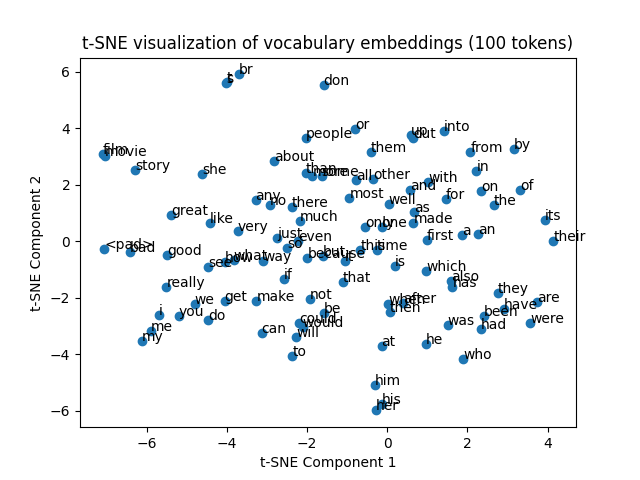

In [22]:
# Plot embeddings of first 100 words using t-SNE
nextplot()
_ = tsne_vocab(glove_embeddings, torch.arange(100), vocab)

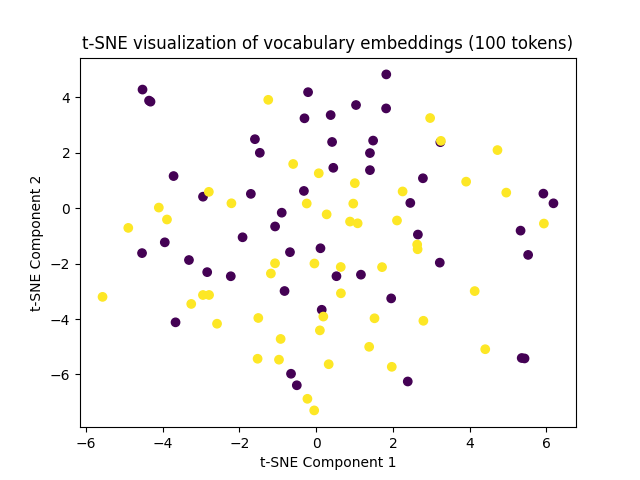

In [23]:
# You can also specify colors and/or drop the item labels
nextplot()
_ = tsne_vocab(glove_embeddings, torch.arange(100), colors=[0] * 50 + [1] * 50)

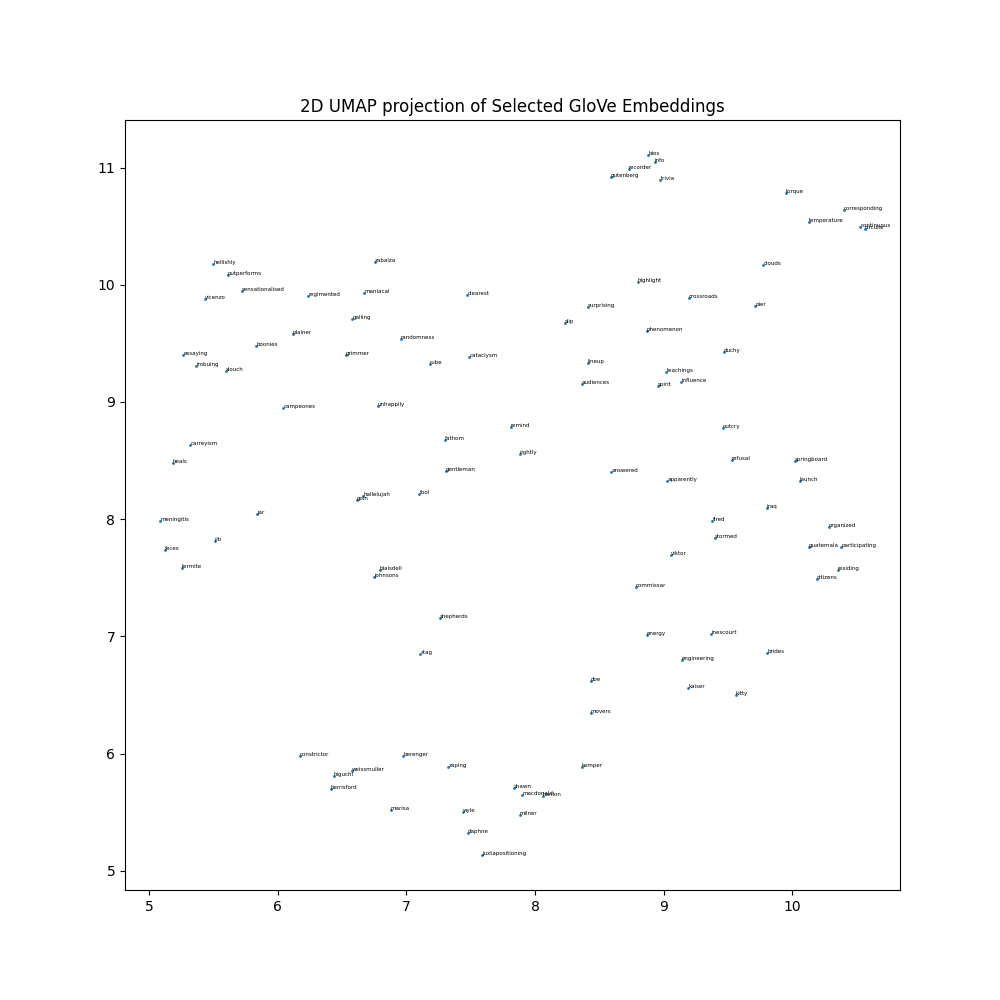

In [24]:
import umap

embeddings = glove_embeddings.weight.detach().cpu().numpy()
indices = np.random.choice(range(len(vocab)), 100, replace=False)
selected_embeddings = embeddings[indices]
selected_words = [vocab.get_itos()[i] for i in indices]
reducer = umap.UMAP(n_neighbors=5, n_components=2, metric='cosine')
umap_embeddings = reducer.fit_transform(selected_embeddings)
plt.figure(figsize=(10, 10))

plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=1)
plt.title('2D UMAP projection of Selected GloVe Embeddings')
for i, word in enumerate(selected_words):
    plt.annotate(word, (umap_embeddings[i, 0], umap_embeddings[i, 1]), fontsize=4)
plt.show()

### Task 4c

In [25]:
# hyperparameter settings for rest of task 4
vocab_size = len(dataset.vocab)
embedding_dim = 100
hidden_dim = 100
num_layers = 2
n_epochs = 10
cell_dropout = 0.0

In [26]:
# train a plain model
model = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, cell_dropout).to(
    DEVICE
)
reviews_train(model, train_loader, val_loader, epochs=n_epochs)

# Should reach a (train) accuracy of >0.9. If not, rerun.

Epoch  1	train accuracy: 0.4928	train loss: 0.6999
            val accuracy: 0.4825	val loss: 0.6957
Epoch  2	train accuracy: 0.4928	train loss: 0.6938
            val accuracy: 0.4825	val loss: 0.6934
Epoch  3	train accuracy: 0.5106	train loss: 0.6929
            val accuracy: 0.4725	val loss: 0.6939
Epoch  4	train accuracy: 0.5316	train loss: 0.6897
            val accuracy: 0.5000	val loss: 0.6998
Epoch  5	train accuracy: 0.6009	train loss: 0.6364
            val accuracy: 0.5200	val loss: 0.7398
Epoch  6	train accuracy: 0.6500	train loss: 0.5464
            val accuracy: 0.4950	val loss: 0.8098
Epoch  7	train accuracy: 0.7472	train loss: 0.4570
            val accuracy: 0.6175	val loss: 0.8547
Epoch  8	train accuracy: 0.8853	train loss: 0.2865
            val accuracy: 0.6675	val loss: 0.8698
Epoch  9	train accuracy: 0.9500	train loss: 0.1435
            val accuracy: 0.7125	val loss: 0.8566
Epoch 10	train accuracy: 0.9812	train loss: 0.0560
            val accuracy: 0.7350	val los

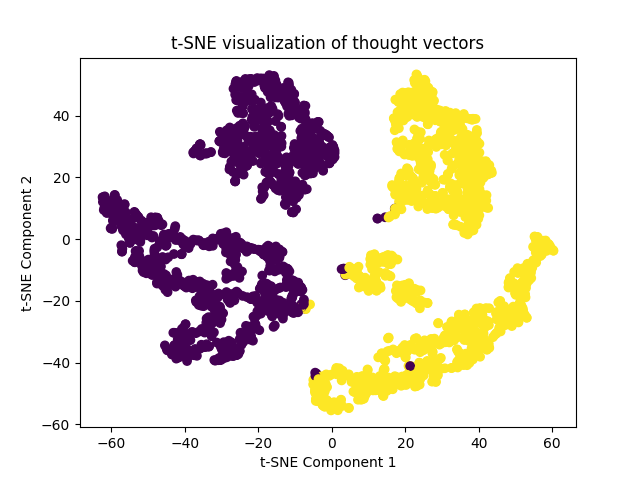

In [27]:
# Plot t-SNE embeddings of the thought vectors for training data
# point color = label
nextplot()
_ = tsne_thought(model, train_loader, DEVICE)

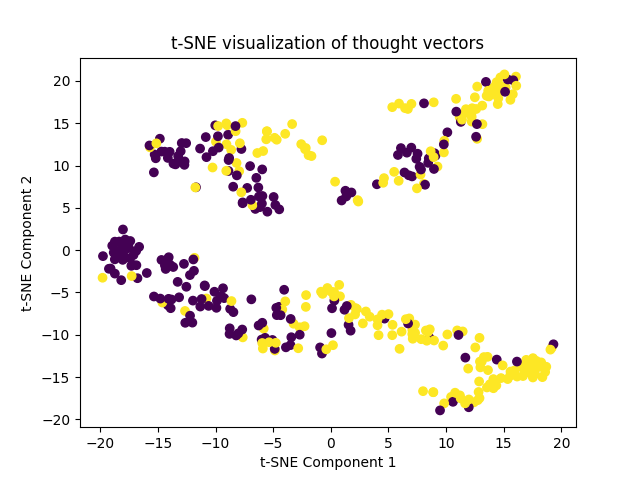

In [28]:
# Plot t-SNE embeddings of the thought vectors for validation data
nextplot()
_ = tsne_thought(model, val_loader, DEVICE)

### Task 4d

In [29]:
# Initialize the model with pre-trained embeddings with finetuning, then train
model_pf = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, cell_dropout)
reviews_load_embeddings(model_pf.embedding, vocab.get_stoi())
reviews_train(model_pf, train_loader, val_loader, epochs=n_epochs)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.4888	train loss: 0.6950
            val accuracy: 0.4850	val loss: 0.6932
Epoch  2	train accuracy: 0.5153	train loss: 0.6905
            val accuracy: 0.5200	val loss: 0.6928
Epoch  3	train accuracy: 0.5141	train loss: 0.6928
            val accuracy: 0.4850	val loss: 0.6932
Epoch  4	train accuracy: 0.5425	train loss: 0.6826
            val accuracy: 0.4950	val loss: 0.6943
Epoch  5	train accuracy: 0.6425	train loss: 0.5942
            val accuracy: 0.6900	val loss: 0.6207
Epoch  6	train accuracy: 0.8213	train loss: 0.3973
            val accuracy: 0.7550	val loss: 0.5638
Epoch  7	train accuracy: 0.9031	train loss: 0.2660
            val accuracy: 0.7825	val loss: 0.5483
Epoch  8	train accuracy: 0.9337	train loss: 0.1904
            val accuracy: 0.7950	val loss: 0.6733
Epoch  9	train accuracy: 0.9547	train loss: 0.1314
            val accuracy: 0.7650	val 

### Task 4e

In [30]:
# Initialize the model with pre-trained embeddings without finetuning, then train
model_p = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, cell_dropout)
reviews_load_embeddings(model_p.embedding, vocab.get_stoi())
model_p.embedding.weight.requires_grad = False
reviews_train(model_p, train_loader, val_loader, epochs=n_epochs)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.4928	train loss: 0.6951
            val accuracy: 0.5125	val loss: 0.6931
Epoch  2	train accuracy: 0.5141	train loss: 0.6929
            val accuracy: 0.5200	val loss: 0.6919
Epoch  3	train accuracy: 0.5162	train loss: 0.6896
            val accuracy: 0.4875	val loss: 0.8306
Epoch  4	train accuracy: 0.5262	train loss: 0.6957
            val accuracy: 0.4900	val loss: 0.6936
Epoch  5	train accuracy: 0.5509	train loss: 0.6783
            val accuracy: 0.5100	val loss: 0.6943
Epoch  6	train accuracy: 0.5766	train loss: 0.6511
            val accuracy: 0.5025	val loss: 0.7334
Epoch  7	train accuracy: 0.6075	train loss: 0.6163
            val accuracy: 0.5825	val loss: 0.7070
Epoch  8	train accuracy: 0.6972	train loss: 0.5623
            val accuracy: 0.7125	val loss: 0.6833
Epoch  9	train accuracy: 0.7309	train loss: 0.5567
            val accuracy: 0.6875	val 

## Task 5: Exploration

#### Task 5a

In [31]:
class SimpleLSTM(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim, hidden_dim, num_layers=1, cell_type = "lstm", cell_dropout=0.0, bidirectional=False
    ):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.cell_dropout = cell_dropout
        self.cell_type = cell_type
        self.bidirectional = bidirectional
        if self.cell_type == "lstm":
            self.rnn = torch.nn.LSTM(embedding_dim, hidden_dim, num_layers = num_layers, batch_first = True, dropout = cell_dropout, bidirectional=self.bidirectional)
        elif self.cell_type == "gru":
            self.rnn = torch.nn.GRU(embedding_dim, hidden_dim, num_layers = num_layers, batch_first = True, dropout = cell_dropout, bidirectional=self.bidirectional)
        elif self.cell_type == "elman":
            self.rnn = torch.nn.RNN(embedding_dim, hidden_dim, num_layers = num_layers, batch_first = True, dropout = cell_dropout, bidirectional=self.bidirectional)
        self.fc = nn.Linear(hidden_dim * 2 if self.bidirectional else hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.init_hidden(len(x))
        embeddings = self.embedding(x)
        outputs, hidden_state = self.rnn(embeddings, hidden)
        if self.bidirectional:
            if self.cell_type == "lstm":
                hidden_state = torch.cat((hidden_state[0][-2,:,:], hidden_state[0][-1,:,:]), dim = 1)
            else:
                hidden_state = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        else:
            if self.cell_type == "lstm":
                hidden_state = hidden_state[0][-1,:,:]
            else:
                hidden_state = hidden_state[-1,:,:]
        thought_vector = hidden_state
        logits = self.fc(thought_vector)
        predictions = self.sigmoid(logits)
        return predictions, thought_vector

    def init_hidden(self, batch_size):
        num_directions = 2 if self.bidirectional else 1
        if self.cell_type == "lstm":
            hidden = (torch.zeros(self.num_layers * num_directions, batch_size, self.hidden_dim, device = self.embedding.weight.device),
                    torch.zeros(self.num_layers * num_directions, batch_size, self.hidden_dim, device = self.embedding.weight.device))
        else:
            hidden = torch.zeros(self.num_layers * num_directions, batch_size, self.hidden_dim, device = self.embedding.weight.device)
        return hidden

##### dropout = 0.0 and Bidirectional LSTM

In [32]:
# Initialize the model with pre-trained embeddings with finetuning, then train
model_pf = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, "lstm", 0.0, True)
reviews_load_embeddings(model_pf.embedding, vocab.get_stoi())
reviews_train(model_pf, train_loader, val_loader, epochs=n_epochs)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.5153	train loss: 0.6936
            val accuracy: 0.5200	val loss: 0.6912
Epoch  2	train accuracy: 0.6497	train loss: 0.6190
            val accuracy: 0.6600	val loss: 0.6246
Epoch  3	train accuracy: 0.8825	train loss: 0.2839
            val accuracy: 0.8225	val loss: 0.4654
Epoch  4	train accuracy: 0.9825	train loss: 0.0585
            val accuracy: 0.8725	val loss: 0.4033
Epoch  5	train accuracy: 0.9975	train loss: 0.0158
            val accuracy: 0.8125	val loss: 0.7838
Epoch  6	train accuracy: 0.9991	train loss: 0.0060
            val accuracy: 0.8850	val loss: 0.5905
Epoch  7	train accuracy: 0.9997	train loss: 0.0026
            val accuracy: 0.8625	val loss: 0.6895
Epoch  8	train accuracy: 0.9997	train loss: 0.0022
            val accuracy: 0.8650	val loss: 0.7565
Epoch  9	train accuracy: 0.9997	train loss: 0.0028
            val accuracy: 0.8725	val 

In [33]:
nextplot()
_ = tsne_thought(model_pf, train_loader, DEVICE)

<IPython.core.display.Javascript object>

In [34]:
nextplot()
_ = tsne_thought(model_pf, val_loader, DEVICE)

<IPython.core.display.Javascript object>

##### dropout = 0.0 and Unidirectional LSTM

In [35]:
# Initialize the model with pre-trained embeddings with finetuning, then train
model_pf = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, "lstm", 0.0, False)
reviews_load_embeddings(model_pf.embedding, vocab.get_stoi())
reviews_train(model_pf, train_loader, val_loader, epochs=n_epochs)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.5059	train loss: 0.6947
            val accuracy: 0.4825	val loss: 0.6934
Epoch  2	train accuracy: 0.5587	train loss: 0.6769
            val accuracy: 0.5200	val loss: 0.7043
Epoch  3	train accuracy: 0.7847	train loss: 0.4528
            val accuracy: 0.7250	val loss: 0.5789
Epoch  4	train accuracy: 0.9453	train loss: 0.1758
            val accuracy: 0.8150	val loss: 0.5023
Epoch  5	train accuracy: 0.9825	train loss: 0.0616
            val accuracy: 0.7900	val loss: 0.6953
Epoch  6	train accuracy: 0.9944	train loss: 0.0234
            val accuracy: 0.8100	val loss: 0.7986
Epoch  7	train accuracy: 0.9950	train loss: 0.0162
            val accuracy: 0.8025	val loss: 0.8413
Epoch  8	train accuracy: 0.9984	train loss: 0.0065
            val accuracy: 0.8275	val loss: 0.8040
Epoch  9	train accuracy: 0.9994	train loss: 0.0037
            val accuracy: 0.8125	val 

In [36]:
nextplot()
_ = tsne_thought(model_pf, train_loader, DEVICE)

<IPython.core.display.Javascript object>

In [37]:
nextplot()
_ = tsne_thought(model_pf, val_loader, DEVICE)

<IPython.core.display.Javascript object>

##### dropout = 0.8 and Bidirectional LSTM

In [38]:
# Initialize the model with pre-trained embeddings with finetuning, then train
model_pf = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, "lstm", 0.8, True)
reviews_load_embeddings(model_pf.embedding, vocab.get_stoi())
reviews_train(model_pf, train_loader, val_loader, epochs=n_epochs)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.5344	train loss: 0.6954
            val accuracy: 0.5750	val loss: 0.6695
Epoch  2	train accuracy: 0.7959	train loss: 0.4776
            val accuracy: 0.8450	val loss: 0.3934
Epoch  3	train accuracy: 0.9547	train loss: 0.1494
            val accuracy: 0.8475	val loss: 0.4576
Epoch  4	train accuracy: 0.9888	train loss: 0.0437
            val accuracy: 0.8525	val loss: 0.4935
Epoch  5	train accuracy: 0.9962	train loss: 0.0158
            val accuracy: 0.8700	val loss: 0.5725
Epoch  6	train accuracy: 0.9991	train loss: 0.0033
            val accuracy: 0.8875	val loss: 0.7494
Epoch  7	train accuracy: 0.9988	train loss: 0.0051
            val accuracy: 0.8750	val loss: 0.9261
Epoch  8	train accuracy: 1.0000	train loss: 0.0004
            val accuracy: 0.8700	val loss: 1.0151
Epoch  9	train accuracy: 1.0000	train loss: 0.0002
            val accuracy: 0.8725	val 

In [39]:
nextplot()
_ = tsne_thought(model_pf, train_loader, DEVICE)

<IPython.core.display.Javascript object>

In [40]:
nextplot()
_ = tsne_thought(model_pf, val_loader, DEVICE)

<IPython.core.display.Javascript object>

##### dropout = 0.8 and Unidirectional LSTM

In [41]:
# Initialize the model with pre-trained embeddings with finetuning, then train
model_pf = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, "lstm", 0.8, False)
reviews_load_embeddings(model_pf.embedding, vocab.get_stoi())
reviews_train(model_pf, train_loader, val_loader, epochs=n_epochs)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.4994	train loss: 0.6969
            val accuracy: 0.5075	val loss: 0.6928
Epoch  2	train accuracy: 0.5094	train loss: 0.6939
            val accuracy: 0.5200	val loss: 0.6924
Epoch  3	train accuracy: 0.5119	train loss: 0.6934
            val accuracy: 0.4775	val loss: 0.6948
Epoch  4	train accuracy: 0.5659	train loss: 0.6711
            val accuracy: 0.5300	val loss: 0.7126
Epoch  5	train accuracy: 0.7362	train loss: 0.5129
            val accuracy: 0.7175	val loss: 0.5927
Epoch  6	train accuracy: 0.8416	train loss: 0.3847
            val accuracy: 0.7075	val loss: 0.6334
Epoch  7	train accuracy: 0.8959	train loss: 0.2774
            val accuracy: 0.7825	val loss: 0.6471
Epoch  8	train accuracy: 0.9306	train loss: 0.1926
            val accuracy: 0.7575	val loss: 0.7533
Epoch  9	train accuracy: 0.9503	train loss: 0.1389
            val accuracy: 0.7925	val 

In [42]:
nextplot()
_ = tsne_thought(model_pf, train_loader, DEVICE)

<IPython.core.display.Javascript object>

In [43]:
nextplot()
_ = tsne_thought(model_pf, val_loader, DEVICE)

<IPython.core.display.Javascript object>

##### dropout = 0.0 and Bidirectional GRU cell

In [44]:
# Initialize the model with pre-trained embeddings with finetuning, then train
model_pf = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, "gru", 0.0, True)
reviews_load_embeddings(model_pf.embedding, vocab.get_stoi())
reviews_train(model_pf, train_loader, val_loader, epochs=n_epochs)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.6669	train loss: 0.5916
            val accuracy: 0.8575	val loss: 0.3338
Epoch  2	train accuracy: 0.9459	train loss: 0.1500
            val accuracy: 0.8500	val loss: 0.4900
Epoch  3	train accuracy: 0.9947	train loss: 0.0132
            val accuracy: 0.8825	val loss: 0.3875
Epoch  4	train accuracy: 1.0000	train loss: 0.0011
            val accuracy: 0.8825	val loss: 0.5293
Epoch  5	train accuracy: 1.0000	train loss: 0.0001
            val accuracy: 0.8825	val loss: 0.5686
Epoch  6	train accuracy: 1.0000	train loss: 0.0001
            val accuracy: 0.8825	val loss: 0.5944
Epoch  7	train accuracy: 1.0000	train loss: 0.0000
            val accuracy: 0.8800	val loss: 0.6148
Epoch  8	train accuracy: 1.0000	train loss: 0.0000
            val accuracy: 0.8825	val loss: 0.6330
Epoch  9	train accuracy: 1.0000	train loss: 0.0000
            val accuracy: 0.8800	val 

In [45]:
nextplot()
_ = tsne_thought(model_pf, train_loader, DEVICE)

<IPython.core.display.Javascript object>

In [46]:
nextplot()
_ = tsne_thought(model_pf, val_loader, DEVICE)

<IPython.core.display.Javascript object>

##### dropout = 0.0 and Unidirectional GRU cell

In [47]:
# Initialize the model with pre-trained embeddings with finetuning, then train
model_pf = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, "gru", 0.0, False)
reviews_load_embeddings(model_pf.embedding, vocab.get_stoi())
reviews_train(model_pf, train_loader, val_loader, epochs=n_epochs)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.5322	train loss: 0.7050
            val accuracy: 0.5200	val loss: 0.6764
Epoch  2	train accuracy: 0.8641	train loss: 0.3154
            val accuracy: 0.8400	val loss: 0.3655
Epoch  3	train accuracy: 0.9894	train loss: 0.0372
            val accuracy: 0.8100	val loss: 0.5831
Epoch  4	train accuracy: 0.9991	train loss: 0.0060
            val accuracy: 0.8550	val loss: 0.5755
Epoch  5	train accuracy: 1.0000	train loss: 0.0008
            val accuracy: 0.8550	val loss: 0.6149
Epoch  6	train accuracy: 1.0000	train loss: 0.0002
            val accuracy: 0.8550	val loss: 0.6737
Epoch  7	train accuracy: 1.0000	train loss: 0.0001
            val accuracy: 0.8500	val loss: 0.7097
Epoch  8	train accuracy: 1.0000	train loss: 0.0001
            val accuracy: 0.8525	val loss: 0.7359
Epoch  9	train accuracy: 1.0000	train loss: 0.0001
            val accuracy: 0.8525	val 

In [48]:
nextplot()
_ = tsne_thought(model_pf, train_loader, DEVICE)

<IPython.core.display.Javascript object>

In [49]:
nextplot()
_ = tsne_thought(model_pf, val_loader, DEVICE)

<IPython.core.display.Javascript object>

##### dropout = 0.8 and Bidirectional GRU cell

In [50]:
# Initialize the model with pre-trained embeddings with finetuning, then train
model_pf = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, "gru", 0.8, True)
reviews_load_embeddings(model_pf.embedding, vocab.get_stoi())
reviews_train(model_pf, train_loader, val_loader, epochs=n_epochs)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.6109	train loss: 0.6316
            val accuracy: 0.8400	val loss: 0.3623
Epoch  2	train accuracy: 0.9187	train loss: 0.2101
            val accuracy: 0.8650	val loss: 0.2781
Epoch  3	train accuracy: 0.9931	train loss: 0.0271
            val accuracy: 0.8800	val loss: 0.3600
Epoch  4	train accuracy: 0.9984	train loss: 0.0047
            val accuracy: 0.8975	val loss: 0.4498
Epoch  5	train accuracy: 0.9997	train loss: 0.0018
            val accuracy: 0.8325	val loss: 0.7805
Epoch  6	train accuracy: 1.0000	train loss: 0.0003
            val accuracy: 0.8650	val loss: 0.6496
Epoch  7	train accuracy: 1.0000	train loss: 0.0001
            val accuracy: 0.8625	val loss: 0.6812
Epoch  8	train accuracy: 1.0000	train loss: 0.0001
            val accuracy: 0.8625	val loss: 0.6990
Epoch  9	train accuracy: 1.0000	train loss: 0.0000
            val accuracy: 0.8700	val 

In [51]:
nextplot()
_ = tsne_thought(model_pf, train_loader, DEVICE)

<IPython.core.display.Javascript object>

In [52]:
nextplot()
_ = tsne_thought(model_pf, val_loader, DEVICE)

<IPython.core.display.Javascript object>

##### dropout = 0.8 and Unidirectional GRU cell

In [53]:
# Initialize the model with pre-trained embeddings with finetuning, then train
model_pf = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, "gru", 0.8, False)
reviews_load_embeddings(model_pf.embedding, vocab.get_stoi())
reviews_train(model_pf, train_loader, val_loader, epochs=n_epochs)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.4950	train loss: 0.7115
            val accuracy: 0.5400	val loss: 0.6942
Epoch  2	train accuracy: 0.7709	train loss: 0.4559
            val accuracy: 0.8875	val loss: 0.2874
Epoch  3	train accuracy: 0.9738	train loss: 0.0794
            val accuracy: 0.8675	val loss: 0.3262
Epoch  4	train accuracy: 0.9925	train loss: 0.0281
            val accuracy: 0.8525	val loss: 0.5408
Epoch  5	train accuracy: 0.9962	train loss: 0.0122
            val accuracy: 0.8375	val loss: 0.7043
Epoch  6	train accuracy: 0.9969	train loss: 0.0132
            val accuracy: 0.8525	val loss: 0.6726
Epoch  7	train accuracy: 0.9984	train loss: 0.0053
            val accuracy: 0.8525	val loss: 0.6840
Epoch  8	train accuracy: 0.9997	train loss: 0.0008
            val accuracy: 0.8625	val loss: 0.7272
Epoch  9	train accuracy: 1.0000	train loss: 0.0002
            val accuracy: 0.8675	val 

In [54]:
nextplot()
_ = tsne_thought(model_pf, train_loader, DEVICE)

<IPython.core.display.Javascript object>

In [55]:
nextplot()
_ = tsne_thought(model_pf, val_loader, DEVICE)

/Users/ngkokteng/PycharmProjects/Deep Learning/a02helper.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()  # this creates a new plot


<IPython.core.display.Javascript object>

##### dropout = 0.0 and Bidirectional Elman cell

In [56]:
# Initialize the model with pre-trained embeddings with finetuning, then train
model_pf = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, "elman", 0.0, True)
reviews_load_embeddings(model_pf.embedding, vocab.get_stoi())
reviews_train(model_pf, train_loader, val_loader, epochs=n_epochs)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.4938	train loss: 0.7359
            val accuracy: 0.5150	val loss: 0.6911
Epoch  2	train accuracy: 0.5397	train loss: 0.6953
            val accuracy: 0.5175	val loss: 0.7046
Epoch  3	train accuracy: 0.5978	train loss: 0.6388
            val accuracy: 0.5150	val loss: 0.7251
Epoch  4	train accuracy: 0.6309	train loss: 0.5988
            val accuracy: 0.5350	val loss: 0.7613
Epoch  5	train accuracy: 0.6331	train loss: 0.5680
            val accuracy: 0.5100	val loss: 0.7523
Epoch  6	train accuracy: 0.6841	train loss: 0.5432
            val accuracy: 0.5175	val loss: 0.8615
Epoch  7	train accuracy: 0.6891	train loss: 0.5293
            val accuracy: 0.5175	val loss: 0.8810
Epoch  8	train accuracy: 0.7169	train loss: 0.5031
            val accuracy: 0.5250	val loss: 0.8497
Epoch  9	train accuracy: 0.7441	train loss: 0.4725
            val accuracy: 0.5150	val 

In [57]:
nextplot()
_ = tsne_thought(model_pf, train_loader, DEVICE)

<IPython.core.display.Javascript object>

In [58]:
nextplot()
_ = tsne_thought(model_pf, val_loader, DEVICE)

<IPython.core.display.Javascript object>

##### dropout = 0.0 and Unidirectional Elman cell

In [59]:
# Initialize the model with pre-trained embeddings with finetuning, then train
model_pf = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, "elman", 0.0, False)
reviews_load_embeddings(model_pf.embedding, vocab.get_stoi())
reviews_train(model_pf, train_loader, val_loader, epochs=n_epochs)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.5031	train loss: 0.7110
            val accuracy: 0.4900	val loss: 0.7198
Epoch  2	train accuracy: 0.4988	train loss: 0.7147
            val accuracy: 0.4900	val loss: 0.7369
Epoch  3	train accuracy: 0.5069	train loss: 0.7033
            val accuracy: 0.5125	val loss: 0.7259
Epoch  4	train accuracy: 0.5331	train loss: 0.6972
            val accuracy: 0.4800	val loss: 0.7732
Epoch  5	train accuracy: 0.5909	train loss: 0.6410
            val accuracy: 0.4825	val loss: 0.7592
Epoch  6	train accuracy: 0.6291	train loss: 0.5651
            val accuracy: 0.5050	val loss: 0.8354
Epoch  7	train accuracy: 0.6656	train loss: 0.5252
            val accuracy: 0.4725	val loss: 0.8923
Epoch  8	train accuracy: 0.6872	train loss: 0.5092
            val accuracy: 0.4900	val loss: 1.0059
Epoch  9	train accuracy: 0.6903	train loss: 0.4769
            val accuracy: 0.4850	val 

In [60]:
nextplot()
_ = tsne_thought(model_pf, train_loader, DEVICE)

<IPython.core.display.Javascript object>

In [61]:
nextplot()
_ = tsne_thought(model_pf, val_loader, DEVICE)

<IPython.core.display.Javascript object>

##### dropout = 0.8 and Bidirectional Elman cell

In [62]:
# Initialize the model with pre-trained embeddings with finetuning, then train
model_pf = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, "elman", 0.8, True)
reviews_load_embeddings(model_pf.embedding, vocab.get_stoi())
reviews_train(model_pf, train_loader, val_loader, epochs=n_epochs)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.5162	train loss: 0.7370
            val accuracy: 0.5200	val loss: 0.7861
Epoch  2	train accuracy: 0.5025	train loss: 0.7300
            val accuracy: 0.4900	val loss: 0.7550
Epoch  3	train accuracy: 0.5259	train loss: 0.7108
            val accuracy: 0.5275	val loss: 0.6960
Epoch  4	train accuracy: 0.5737	train loss: 0.6883
            val accuracy: 0.5575	val loss: 0.7151
Epoch  5	train accuracy: 0.6391	train loss: 0.6328
            val accuracy: 0.5275	val loss: 0.7374
Epoch  6	train accuracy: 0.6666	train loss: 0.5889
            val accuracy: 0.5150	val loss: 0.8033
Epoch  7	train accuracy: 0.6744	train loss: 0.5680
            val accuracy: 0.4950	val loss: 0.8134
Epoch  8	train accuracy: 0.6863	train loss: 0.5529
            val accuracy: 0.5100	val loss: 0.8096
Epoch  9	train accuracy: 0.6903	train loss: 0.5256
            val accuracy: 0.5300	val 

In [63]:
nextplot()
_ = tsne_thought(model_pf, train_loader, DEVICE)

<IPython.core.display.Javascript object>

In [64]:
nextplot()
_ = tsne_thought(model_pf, val_loader, DEVICE)

<IPython.core.display.Javascript object>

##### dropout = 0.8 and Unidirectional Elman cell

In [65]:
# Initialize the model with pre-trained embeddings with finetuning, then train
model_pf = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, "elman", 0.8, False)
reviews_load_embeddings(model_pf.embedding, vocab.get_stoi())
reviews_train(model_pf, train_loader, val_loader, epochs=n_epochs)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.5019	train loss: 0.7204
            val accuracy: 0.5200	val loss: 0.7056
Epoch  2	train accuracy: 0.4963	train loss: 0.7126
            val accuracy: 0.4800	val loss: 0.7280
Epoch  3	train accuracy: 0.4884	train loss: 0.7076
            val accuracy: 0.5200	val loss: 0.6958
Epoch  4	train accuracy: 0.5016	train loss: 0.7114
            val accuracy: 0.5200	val loss: 0.7087
Epoch  5	train accuracy: 0.5012	train loss: 0.7293
            val accuracy: 0.5200	val loss: 0.6931
Epoch  6	train accuracy: 0.5034	train loss: 0.7132
            val accuracy: 0.4800	val loss: 0.7031
Epoch  7	train accuracy: 0.5016	train loss: 0.7079
            val accuracy: 0.4900	val loss: 0.6942
Epoch  8	train accuracy: 0.4938	train loss: 0.7046
            val accuracy: 0.4800	val loss: 0.7347
Epoch  9	train accuracy: 0.4975	train loss: 0.7195
            val accuracy: 0.5200	val 

In [66]:
nextplot()
_ = tsne_thought(model_pf, train_loader, DEVICE)

<IPython.core.display.Javascript object>

In [67]:
nextplot()
_ = tsne_thought(model_pf, val_loader, DEVICE)

<IPython.core.display.Javascript object>

#### Task 5b

In [48]:
@torch.no_grad()
def reviews_eval(
    model, eval_loader, label="val", loss_fn=torch.nn.functional.binary_cross_entropy
):
    model.to(DEVICE)
    model.eval()

    total_correct = total_loss = 0
    for reviews, labels in eval_loader:
        reviews, labels = reviews.to(DEVICE), labels.to(DEVICE)

        prediction, _ = model(reviews)
        prediction = prediction.view(-1)
        loss = loss_fn(prediction, labels.float())
        
        total_loss = total_loss + loss.item()
        prediction_class = torch.round(prediction)
        correct = (prediction_class == labels).sum().item()
        total_correct = total_correct + correct

    val_loss = total_loss / len(eval_loader)
    val_accuracy = total_correct / len(eval_loader.dataset)
    
    print(
        f"            "
        f"{label} accuracy: {val_accuracy:.4f}\t"
        f"{label} loss: {val_loss:.4f}"
    )
    
    return val_loss


In [78]:
def reviews_train(
    model,
    train_loader,
    val_loader,
    lr=0.01,
    epochs=3,
    max_norm=5,
    loss_fn=torch.nn.functional.binary_cross_entropy,
    patience = 3,
):
    model = model.to(DEVICE)

    optimizer = torch.optim.Adam(
        [param for param in model.parameters() if param.requires_grad], lr=lr
    )

    best_val_loss = float("inf")
    patience_counter = 0
    for epoch in range(epochs):
        total_correct = total_loss = 0
        for reviews, labels in train_loader:
            model.train()

            reviews, labels = reviews.to(DEVICE), labels.to(DEVICE)

            prediction, _ = model(reviews)
            prediction = prediction.view(-1)
            loss = loss_fn(prediction, labels.float())

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = max_norm)
            optimizer.step()
            optimizer.zero_grad()

            total_loss = total_loss + loss.item()
            prediction_class = torch.round(prediction)
            correct = (prediction_class == labels).sum().item()
            total_correct = total_correct + correct
        
        val_loss = reviews_eval(model, val_loader, loss_fn=loss_fn)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"model_best_val_loss.pt")
            patience_counter = 0
        else:
            patience_counter += 1
        print(
            f"Epoch {epoch + 1:2}\t"
            f"train accuracy: {total_correct / len(train_loader.dataset):.4f}\t"
            f"train loss: {total_loss / len(train_loader):.4f}"
        )
        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs with no validation loss improvement.")
            break
        reviews_eval(model, val_loader, loss_fn=loss_fn)

In [86]:
vocab_size = len(dataset.vocab)
embedding_dim = 100
hidden_dim = 80
num_layers = 2
n_epochs = 10
cell_dropout = 0.5
bidirectional = True
cell_type = "gru"

In [87]:
model_pf = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, cell_type, cell_dropout, bidirectional)
reviews_load_embeddings(model_pf.embedding, vocab.get_stoi())
reviews_train(model_pf, train_loader, val_loader, epochs=n_epochs)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
            val accuracy: 0.7925	val loss: 0.4464
Epoch  1	train accuracy: 0.5769	train loss: 0.6650
            val accuracy: 0.7925	val loss: 0.4464
            val accuracy: 0.8850	val loss: 0.2735
Epoch  2	train accuracy: 0.9153	train loss: 0.2143
            val accuracy: 0.8850	val loss: 0.2735
            val accuracy: 0.8925	val loss: 0.3492
Epoch  3	train accuracy: 0.9941	train loss: 0.0166
            val accuracy: 0.8925	val loss: 0.3492
            val accuracy: 0.8650	val loss: 0.5815
Epoch  4	train accuracy: 0.9991	train loss: 0.0046
            val accuracy: 0.8650	val loss: 0.5815
            val accuracy: 0.8600	val loss: 0.7742
Epoch  5	train accuracy: 1.0000	train loss: 0.0005
Early stopping triggered after 3 epochs with no validation loss improvement.


In [88]:
model_pf = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, cell_type, cell_dropout, bidirectional)
model_pf.load_state_dict(torch.load("model_best_val_loss.pt"))
print(" testing loss: ", reviews_eval(model_pf, test_loader, loss_fn = torch.nn.functional.binary_cross_entropy))

            val accuracy: 0.8700	val loss: 0.3336
 testing loss:  0.3335601423795407
